In [2]:
%matplotlib nbagg
#Import required libraries
from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from drawnow import drawnow, figure
from scipy import stats
import scipy.signal as signal
import pandas as pd
import math
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# Functions

In [3]:
def get_rolling_slope(csv_data,is_sensor_data):
    
    #Load sensor
    if is_sensor_data =='load':
        datapnt_delay = 101
        fps = 1000/datapnt_delay
        window_width = 8
        
    elif is_sensor_data =='light':
        datapnt_delay = 163
        fps = 1000/datapnt_delay
        window_width = 8
        
    else:
        #Sampled every 5 seconds - real data
        fps = 1
        window_width = 3
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    if is_sensor_data == 'load':
        volume = 30
        raw_to_grams = volume/125879.0
        conversion_factor =60
        density_milk = 1
        flow_rate = np.multiply(slope,-1*raw_to_grams*(1/density_milk)*conversion_factor)
        
    elif is_sensor_data == 'light':
        syringe_rad = 21.7/2 #Syringe radius in mm
        syringe_area = math.pi*syringe_rad ** 2
        conversion_factor = 0.06
        flow_rate = np.multiply(slope,syringe_area*conversion_factor)
    else:
        density_milk = 1 
        conversion_factor = 60
        time_interval = 5 #5s between data recordings
        flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    return flow_rate

def get_time(csv_data,is_sensor_data):
    if is_sensor_data =='load':
        datapnt_delay = 101
        fps = 1000/datapnt_delay        
    elif is_sensor_data =='light':
        datapnt_delay = 163
        fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time

def process_csv(csv_path,is_sensor_data):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    return csv_data

# Read Data In

In [4]:
#Read sensor data
csv_name_light1 = r'\light_higher_1.csv'
csv_name_light2 = r'\light_higher_2.csv'
csv_name_light3 = r'\light_higher_3.csv'
csv_name_light4 = r'\light_higher_4.csv'

csv_path_light1 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_light1
csv_path_light2 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_light2
csv_path_light3 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_light3
csv_path_light4 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_light4

csv_data_light1 = process_csv(csv_path_light1,'light')[640:2500]
csv_data_light2 = process_csv(csv_path_light2,'light')[640:2100]
csv_data_light3 = process_csv(csv_path_light3,'light')[640:2500]
csv_data_light4 = process_csv(csv_path_light4,'light')[180:]

time_light1 = get_time(csv_data_light1,'light')
time_light2 = get_time(csv_data_light2,'light')
time_light3 = get_time(csv_data_light3,'light')
time_light4 = get_time(csv_data_light4,'light')

#Read real sensor data
csv_name_light_measured = r'\real_light_allresults.csv'
csv_path_light_measured =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_light_measured
csv_data_light_measured = pd.read_csv(csv_path_light_measured)
time_light_measured = csv_data_light_measured['Time (s)']

csv_data_light_measured1 = csv_data_light_measured['Trial 1 15 mL (g)']
csv_data_light_measured2 = csv_data_light_measured['Trial 2 15 mL (g)']
csv_data_light_measured3 = csv_data_light_measured['Trial 3 15 mL (g)']
csv_data_light_measured4 = csv_data_light_measured['Trial 1 30 mL (g)']

#Read load data
csv_name_load1 = r'\LOAD_higher_1.csv'
csv_name_load2 = r'\LOAD_higher_2.csv'
csv_name_load3 = r'\LOAD_higher_3.csv'

csv_path_load1 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_load1
csv_path_load2 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_load2
csv_path_load3 =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_load3

csv_data_load1 = process_csv(csv_path_load1,'load')[650:]
csv_data_load2 = process_csv(csv_path_load2,'load')[650:]
csv_data_load3 = process_csv(csv_path_load3,'load')[650:]

time_load1 = get_time(csv_data_load1,'load')
time_load2 = get_time(csv_data_load2,'load')
time_load3 = get_time(csv_data_load3,'load')

#Read real experimental results from load data
csv_name_load_measured = r'\real_load_allresults.csv'
csv_path_load_measured =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name_load_measured
csv_data_load_measured = pd.read_csv(csv_path_load_measured)
time_load_measured = csv_data_load_measured['Time (s)']

csv_data_load_measured1 = csv_data_load_measured['Trial 1 30 mL (g)']
csv_data_load_measured2 = csv_data_load_measured['Trial 2 30 mL (g)']
csv_data_load_measured3 = csv_data_load_measured['Trial 3 30 mL (g)']

# Light Sensor Raw Data Comparison 

<IPython.core.display.Javascript object>


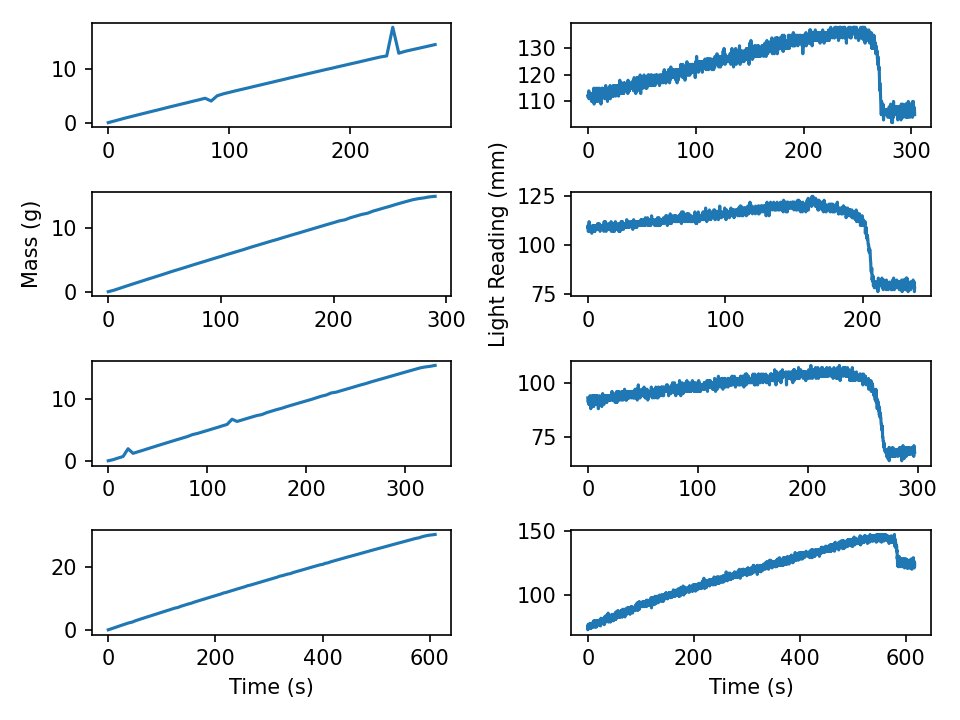

Text(0.5, 0, 'Time (s)')

In [5]:
#Read sensor data
fig, axs = plt.subplots(4,2)
axs[0, 0].plot(time_light_measured,csv_data_light_measured1)

axs[0, 1].plot(time_light1,csv_data_light1)

axs[1, 0].plot(time_light_measured,csv_data_light_measured2)
axs[1,0].set_ylabel('Mass (g)')

axs[1, 1].plot(time_light2,csv_data_light2)
axs[1,1].set_ylabel('Light Reading (mm)')

axs[2,0].plot(time_light_measured,csv_data_light_measured3)

axs[2,1].plot(time_light3,csv_data_light3)

axs[3,0].plot(time_light_measured,csv_data_light_measured4)
axs[3,0].set_xlabel('Time (s)')
axs[3,1].plot(time_light4,csv_data_light4)
axs[3,1].set_xlabel('Time (s)')


# Light Sensor Slope Data Comparison

<IPython.core.display.Javascript object>


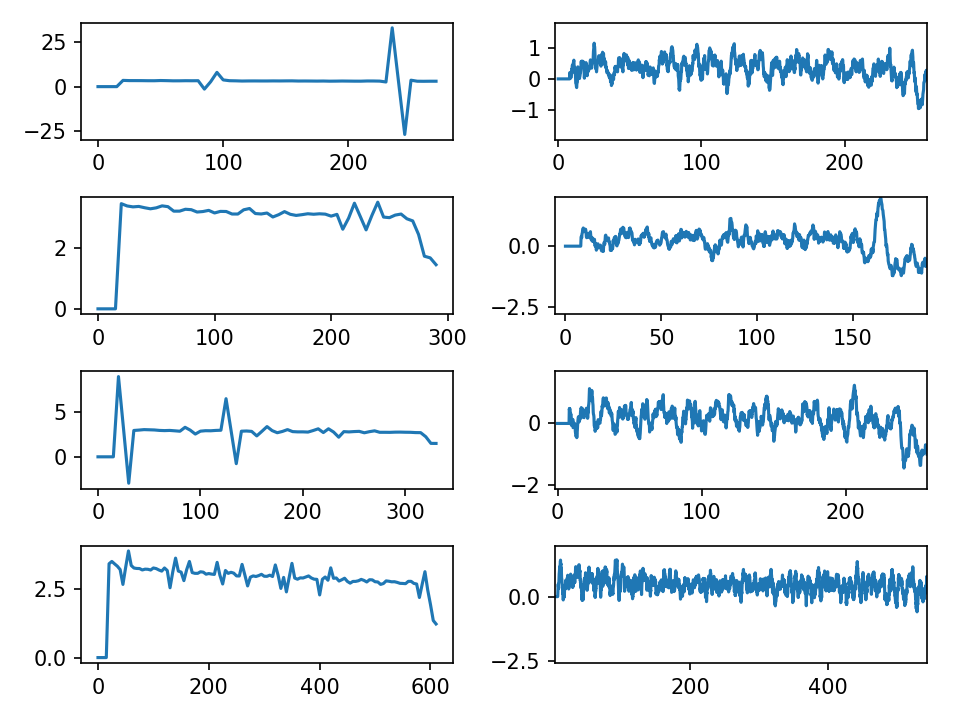

In [6]:
fig, axs_2 = plt.subplots(4,2)
flow_rate_light1 = get_rolling_slope(csv_data_light1,'light')
flow_rate_light2 = get_rolling_slope(csv_data_light2,'light')
flow_rate_light3 = get_rolling_slope(csv_data_light3,'light')
flow_rate_light4 = get_rolling_slope(csv_data_light4,'light')

flow_rate_light_measured1 =get_rolling_slope(csv_data_light_measured1,None)
flow_rate_light_measured2 =get_rolling_slope(csv_data_light_measured2,None)
flow_rate_light_measured3 =get_rolling_slope(csv_data_light_measured3,None)
flow_rate_light_measured4 =get_rolling_slope(csv_data_light_measured4,None)

axs_2[0, 0].plot(time_light_measured,flow_rate_light_measured1)
axs_2[0, 1].plot(time_light1,flow_rate_light1)

axs_2[1, 0].plot(time_light_measured,flow_rate_light_measured2)
axs_2[1, 1].plot(time_light2,flow_rate_light2)

axs_2[2,0].plot(time_light_measured,flow_rate_light_measured3)
axs_2[2,1].plot(time_light3,flow_rate_light3)

axs_2[3,0].plot(time_light_measured,flow_rate_light_measured4)
axs_2[3,1].plot(time_light4,flow_rate_light4)


# Load Sensor Raw Data Comparison 

<IPython.core.display.Javascript object>


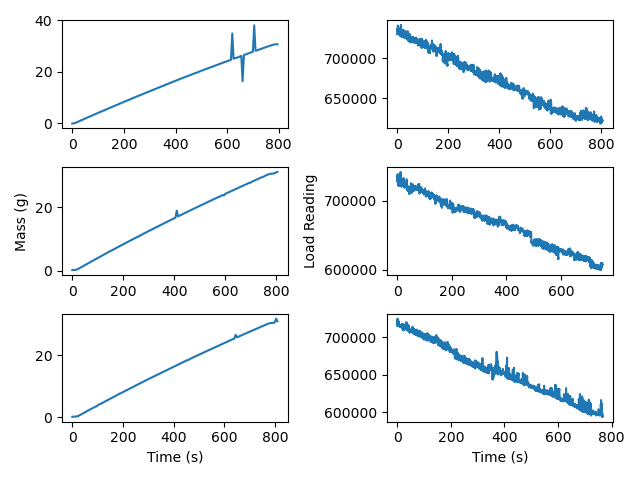

Text(0.5, 0, 'Time (s)')

In [40]:
#Read sensor data
fig, axs_3 = plt.subplots(3,2)
axs_3[0, 0].plot(time_load_measured,csv_data_load_measured1)
axs_3[0, 1].plot(time_load1,csv_data_load1)

axs_3[1, 0].plot(time_load_measured,csv_data_load_measured2)
axs_3[1,0].set_ylabel('Mass (g)')

axs_3[1, 1].plot(time_load2,csv_data_load2)
axs_3[1,1].set_ylabel('Load Reading')

axs_3[2,0].plot(time_load_measured,csv_data_load_measured3)
axs_3[2,0].set_xlabel('Time (s)')

axs_3[2,1].plot(time_load3,csv_data_load3)
axs_3[2,1].set_xlabel('Time (s)')


# Light Sensor Slope Data Comparison

<IPython.core.display.Javascript object>


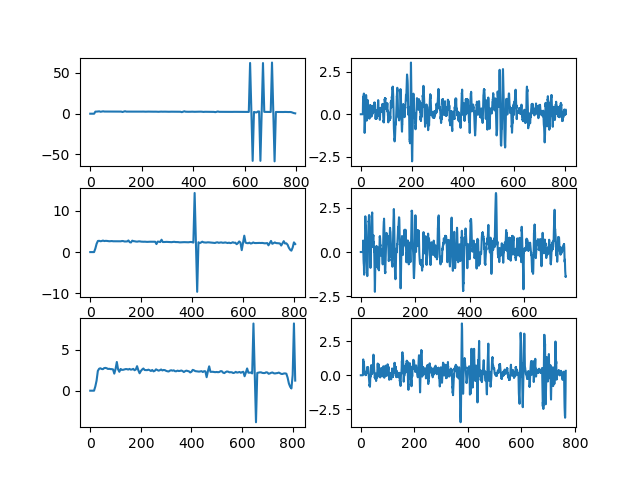

In [29]:
fig, axs_4 = plt.subplots(3,2)
flow_rate_load1 = get_rolling_slope(csv_data_load1,'load')
flow_rate_load2 = get_rolling_slope(csv_data_load2,'load')
flow_rate_load3 = get_rolling_slope(csv_data_load3,'load')

flow_rate_load_measured1 =get_rolling_slope(csv_data_load_measured1,None)
flow_rate_load_measured2 =get_rolling_slope(csv_data_load_measured2,None)
flow_rate_load_measured3 =get_rolling_slope(csv_data_load_measured3,None)

axs_4[0, 0].plot(time_load_measured,flow_rate_load_measured1)
axs_4[0, 1].plot(time_load1,flow_rate_load1)

axs_4[1, 0].plot(time_load_measured,flow_rate_load_measured2)
axs_4[1, 1].plot(time_load2,flow_rate_load2)

axs_4[2,0].plot(time_load_measured,flow_rate_load_measured3)
axs_4[2,1].plot(time_load3,flow_rate_load3)



# Etc

<IPython.core.display.Javascript object>


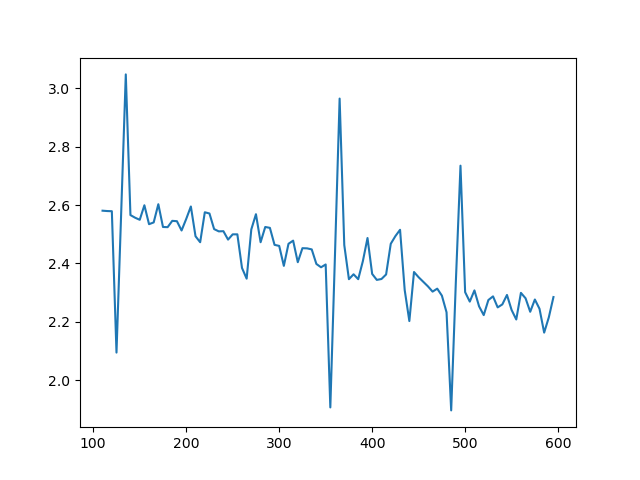

In [14]:
#Read real data
csv_name = r'\real_load_allresults.csv'
csv_path =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name
csv_data = pd.read_csv(csv_path)
slope = get_rolling_slope(csv_data['Trial 1 30 mL (g)'],False)
plt.figure()
plt.plot(csv_data['Time (s)'][22:120],slope[22:120])
plt.show()

<IPython.core.display.Javascript object>


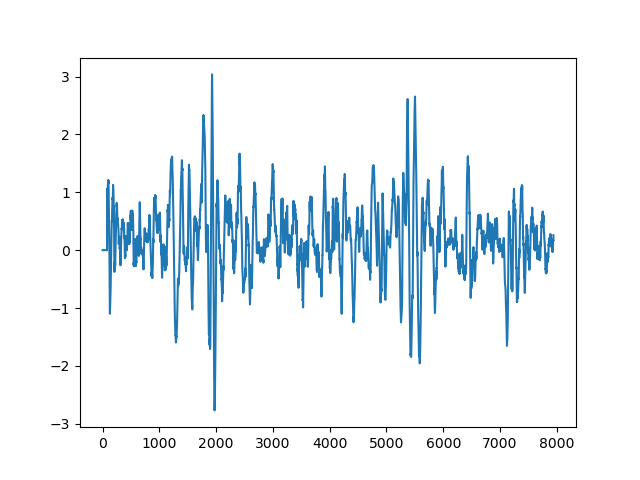

733130.0
622680.0


In [44]:
#Read sensor data
csv_name = r'\LOAD_higher_1.csv'
csv_path =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name
file = open(csv_path)
csvreader = csv.reader(file)
csv_data = np.asarray(list(csvreader))
csv_data = np.asfarray(csv_data,float).flatten()[670:]
slope = get_rolling_slope(csv_data,'load')
fig, (ax2) = plt.subplots(1)
ax2.plot(slope)
print(csv_data[0])
print(csv_data[len(csv_data)-1])

In [40]:
#Make these plots look less shitty

#Trial 1
t1_start = 733130.0
t1_end = 622680.0
#Trial 2
t2_start = 747355
t2_end = 605708
#Trial 3
t3_start = 724357.0
t3_end = 598478.0
print(t1_end-t1_start)
print(t2_end-t2_start)
print(t3_end-t3_start)
diff_avg = (1/3)*((t1_end-t1_start)+(t2_end-t2_start)+(t3_end-t3_start))
diff_avg

-110450.0
-141647
-125879.0


-125992.0